In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
usuario = "ignacio.a.moya.morales@gmail.com"
token = "15ab43b5a6b342295acbec89"
estacion = "330020"  #En este caso agarre el de quinta normal por que era el unico que me sabia
anio = 2020

url = f"https://climatologia.meteochile.gob.cl/application/servicios/getTemperaturaHistoricaDiaria/{estacion}/{anio}"
params = {"usuario": usuario, "token": token}

r = requests.get(url, params=params)
data = r.json()

print(data.keys())    
print(data["hayDatos"])

dict_keys(['pais', 'organismo', 'fechaCreacion', 'producto', 'datosEstacion', 'hayDatos', 'ano', 'datos'])
True


In [9]:
registros = []
for mes, dias in data["datos"].items():
    for dia, valores in dias.items():
        registros.append({
            "fecha": pd.to_datetime(valores["momento"], dayfirst=True),
            "tmax": valores["maxima"],
            "tmin": valores["minima"],
            "tmed": valores["media"]
        })

df = pd.DataFrame(registros).set_index("fecha").sort_index()
print(df.head())

                 tmax  tmin       tmed
fecha                                 
2020-01-01  29.600000  13.7  22.299999
2020-01-02  30.700001  12.5  21.200001
2020-01-03  30.799999  12.2  20.799999
2020-01-04  31.600000  15.3  22.900000
2020-01-05  24.299999  13.5  19.100000


In [ ]:
dfs = []
for anio in range(1981, 2021):  #intentamos sacar todos los años posibles 
    url = f"https://climatologia.meteochile.gob.cl/application/servicios/getTemperaturaHistoricaDiaria/{estacion}/{anio}"
    r = requests.get(url, params={"usuario": usuario, "token": token})
    data = r.json()

    if "hayDatos" in data and data["hayDatos"]:
        for mes, dias in data["datos"].items():
            for dia, valores in dias.items():
                dfs.append({
                    "fecha": pd.to_datetime(valores["momento"], dayfirst=True),
                    "tmax": valores["maxima"],
                    "tmin": valores["minima"],
                    "tmed": valores["media"]
                })

df = pd.DataFrame(dfs).set_index("fecha").sort_index()

In [12]:
df

,tmax,tmin,tmed
fecha,,,
1995-01-01,29.600000,12.8,21.200001
1995-01-02,29.400000,12.4,20.900000
1995-01-03,29.000000,11.7,20.299999
1995-01-04,29.799999,12.2,21.000000
1995-01-05,30.600000,12.8,21.700001
...,...,...,...
2020-12-27,28.700001,12.2,19.500000
2020-12-28,31.400000,13.3,21.900000
2020-12-29,28.200001,13.5,20.700001


In [ ]:
ref = df["1995":"2010"].copy() #tomamos todos los años que existen en el data set 
ref["doy"] = ref.index.dayofyear

# percentil 90 de tmax por dia 
thresholds = ref.groupby("doy")["tmax"].quantile(0.9)

In [ ]:
df["doy"] = df.index.dayofyear
df["umbral"] = df["doy"].map(thresholds)
df["sobre_umbral"] = df["tmax"] > df["umbral"]

In [ ]:
# grupos de días consecutivos
df["grupo"] = (df["sobre_umbral"] != df["sobre_umbral"].shift()).cumsum()

# filtrar solo los grupos que duran 3 o mas días -> catalogo de ola de calor
olas = df[df["sobre_umbral"]].groupby("grupo").filter(lambda x: len(x) >= 3)

#contar número de olas por año
olas_por_año = olas.groupby(olas.index.year)["grupo"].nunique()
print(olas_por_año)

fecha
1995     4
1996     3
1997     6
1998     2
1999     1
2000     1
2001     4
2002     3
2003     6
2004     4
2005     1
2006     7
2007     3
2008     1
2009     8
2010     6
2011     6
2012     7
2013     9
2014     9
2015    11
2016    10
2017     7
2018     5
2019    12
2020    10
Name: grupo, dtype: int64


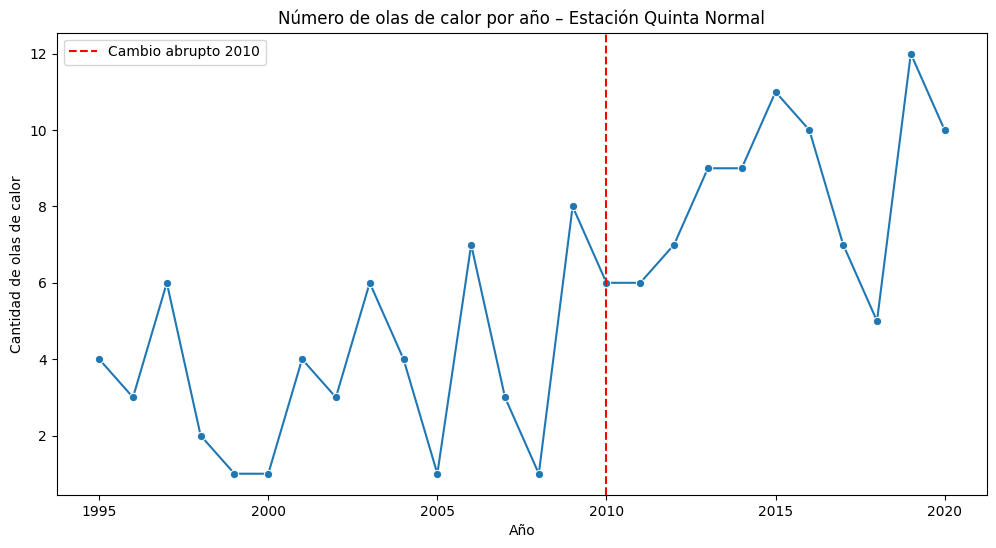

In [16]:
plt.figure(figsize=(12,6))
sns.lineplot(x=olas_por_año.index, y=olas_por_año.values, marker="o")
plt.axvline(2010, color="red", linestyle="--", label="Cambio abrupto 2010")
plt.title("Número de olas de calor por año – Estación Quinta Normal")
plt.xlabel("Año")
plt.ylabel("Cantidad de olas de calor")
plt.legend()
plt.show()